# Lab6 (Teacher version): configuration model

We can use the following libraries.

In [1]:
import matplotlib.pyplot as plt
import math
import sys
import random
import time
import copy
print(sys.version)

3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]


## Exercise 0: preliminaries 

In this prectical work, we use the graph http://lioneltabourier.fr/documents/inet.txt. It is an undirected map of a subpart of the Internet.

Load it in memory as a dictionary of lists (as usual) and make the standard measurements:
* compute its number of nodes and edges
* plot its degree distribution
* compute its number of triangles
* compute a lower bound for its diameter

We indicate here the number of nodes, links and triangles of this network:
* 9740 nodes 
* 35567 edges
* 206909 triangles

In [2]:
def node_link(file_name):
    '''
    node_link(file_name)
    
    Returns the number of edges and the number of nodes in the graph stored in 'file_name'
        Parameters:
            file_name(string) : the name of the file storing the graph
        Returns:
            node_count, link_count (int, int) : a tuple containing the number of nodes and the number of links in 
            the graph
    '''
    node_set = set()
    node_count = 0
    link_count = 0
    with open(file_name, "r") as my_file:
        for line in my_file:
            if line[0] != "#": # supposing that comments start with a '#' symbol
                line = line.split() # supposing a space between two nodes
                node1 = int(line[0]) # supposing that nodes are numbers formated in file
                node2 = int(line[1])
                link_count += 1 # if a same link appears several times, it will be counted as many times
                if node1 not in node_set:
                    node_set.add(node1)
                    node_count += 1
                if node2 not in node_set:
                    node_set.add(node2)
                    node_count +=1  
    return node_count, link_count

In [3]:
def load_clean_graph(input_name, output_name = None):
    '''
    load_clean_graph(input_name, output_name = None)
    
    Delete self-loops and duplicated edges existing in the graph and writes it in a new test file"
        Parameters:
            input_name (string) : name of the file storing the graph with self loops and duplicated edges
            output_name (string) (optional) : name of the file that will store the graph without self 
            loops and duplicated edges. If no output is defined the new graph will not be stored in a file
        Returns:
            my_graph (dictionary of lists) : the graph without self loops and duplicated edges
    '''
    my_graph = {}
    if output_name is not None:
        output_file = open(output_name, "w")
    with open(input_name, "r") as input_file:
        for line in input_file:

            if line[0] != "#":
                line = line.split()
                node1 = int(line[0])
                node2 = int(line[1])
                if node1 != node2:
                    if node1 in my_graph:
                        if node2 not in my_graph[node1]:
                            my_graph[node1].append(node2)
                            if output_name is not None:
                                output_file.write(f"{node1} {node2}\n")
                    else:
                        my_graph[node1] = [node2]
                    if node2 in my_graph:
                        if node1 not in my_graph[node2]:
                            my_graph[node2].append(node1)
                            if output_name is not None:
                                output_file.write(f"{node2} {node1}\n")
                    else:
                        my_graph[node2] = [node1]
    if output_name is not None:
        output_file.close()
    return my_graph
    

In [4]:
def degree_dist(my_graph):
    '''
    degree_dist(my_graph)
    
    Computes the degree distribution of a graph
        Parameters:
            my_graph (dictionary of lists)
        Returns:
            my_degree_dist (dictionary) : a dictionary wich key are the degrees that appear in the graph and 
            the values are the number of occurences
    '''
    my_degree_dist = {}
    for node in my_graph:
        node_degree = len(my_graph[node])
        if node_degree in my_degree_dist:
            my_degree_dist[node_degree] += 1
        else:
            my_degree_dist[node_degree] = 1
    return my_degree_dist

In [5]:
def plot_degree_dist(my_graph, log = True, limits = (0.5, 10000, 0.5, 10000), my_label = "Label"):
    '''
    plot_degree_dist(my_graph)
    
    Plot the degree distribution in log scale
        Parameters:
            my_graph (dictionary of lists)
            log (boolean) (default = True): Plotting the graph with a axis in log scale
            limits (int, int, int, int) (default = (0.5,10000,0.5,10000)) : the limits of the plot with the following format (xmin, xmax, ymin, ymax)
        Returns
    '''
    my_degree_dist = degree_dist(my_graph)
    xmin, xmax, ymin, ymax = limits
    if log:
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    
    plt.scatter(my_degree_dist.keys(), my_degree_dist.values(), label = my_label)
    plt.legend()

In [6]:
def bfs(my_graph):
    '''
    bfs(my_graph)
    
    Evaluate the size of the largest connect component of the graph 'my_graph' by going through all nodes of the 
    graph and identifying the connected component that contains the node
        Parameters:
            my_graph (dictionary of lists)
        Returns:
            my_lcc : the size of the largest connected component of 'my_graph'
    '''
    my_cc = {}
    cc_index = 0
    for source in my_graph.keys():
        if source not in my_cc:
            my_queue = [source]
            marked_node = [source]
            while my_queue:
                node1 = my_queue.pop(0)
                my_cc[node1] = cc_index
                for node2 in my_graph[node1]:
                    if node2 not in marked_node:
                        my_queue.append(node2)
                        marked_node.append(node2)
            cc_index += 1
    
    cc_sizes = {}
    for node in my_cc:
        cc_index = my_cc[node]
        if cc_index in cc_sizes:
            cc_sizes[cc_index] += 1
        else:
            cc_sizes[cc_index] = 1
    return max(list(cc_sizes.values()))
    

In [7]:
def distances(my_graph, source_node):
    '''
    distances(my_graph, source_node)
    
    Returns the distances of each node to the source node as a dictionary
        Parameters:
            my_graph (dictionary of lists)
            source_node (int) : the node from which we will compute the distances
        Returns:
            my_distances : A dictionary which keys are the nodes and the values are the distances from the 
            key to 'source_node'
    '''
    my_queue = [source_node]
    my_distances = {}
    for node in my_graph:
        my_distances[node] = -1
    my_distances[source_node] = 0
    while my_queue:
        node1 = my_queue.pop(0)
        for node2 in my_graph[node1]:
            if my_distances[node2] == -1:
                my_queue.append(node2)
                my_distances[node2] = my_distances[node1] + 1
    return my_distances

def diameter(my_graph, sample_size):
    '''
    diameter(my_graph, sample_size)
    
    Compute an approximate diameter of the  graph 'my_graph' by running a bfs algorithm on a sample of nodes 
    and taking the max of the distances
        Parameters:
            my_graph (dictionary of lists)
            sample_size (int) : the number of nodes in the graph that will be used to find the diameter
        Returns:
            my_diameter (int) : the approximate maximum distance in the graph
    '''
    my_diameter = -1
    nodes = list(my_graph.keys())
    for i in range(sample_size):
        my_distances = distances(my_graph, nodes.pop(random.randint(0,len(nodes) - 1)))
        my_diameter = max(my_diameter, max(list(my_distances.values())))
    return my_diameter

In [8]:
def triangle(my_graph):
    '''
    triangle(my_graph)
    
    Returns the number of triangles in the graph 'my_graph'
        Parameters:
            my_graph (dictionary of lists)
        Returns:
            triangle_count (int) : the number of triangles in the graph
    '''
    triangle_count = 0
    for node1 in my_graph:
        for node2 in my_graph[node1]:
            if node1 < node2:
                for node3 in my_graph[node1]:
                    if node3 in my_graph[node2]: # node3 in N(node1) and N(node2)
                        if node2 < node3:
                            triangle_count += 1
    return triangle_count

In [9]:
def delete_node(my_graph, nodes):
    '''
    delete_node(my_graph, nodes)
    
    Deletes the nodes 'nodes' from the graph 'my_graph'
        Parameters:
            my_graph (dictionary of lists)
            nodes (list) : list of nodes to be deleted
        Return:
        
    '''
    for node1 in nodes:
        for node2 in my_graph[node1]:
            my_graph[node2].remove(node1)
            #TODO catch exception if remove fail
        my_graph.pop(node1, None)
        #TODO raise exception if pop fail => return None
def random_failure(my_graph, limit, step):
    '''
    random_failure(my_graph, limit, step)
    
    Return the evolution of the largest connected component size according to the number of nodes that are 
    deleted from the graph randomly with at most 'limit' nodes deleted with a step of 'step'
        Parameters:
            my_graph (dictionary of lists)
            limit (int) : the total number of nodes that will be deleted
            step (int) : number of nodes to be deleted at each step
        Returns
            my_data (dictionary) : dictionary which key are the numbers of nodes removed and the value the
            size of the largest connected component when the corresponding number of nodes have been deleted 
            from the graph
    
    '''
    my_data = {}
    nodes_left = list(my_graph.keys())
    for key in range(step, limit, step):
        # generation of the nodes to be deleted from the graph
        to_delete = []
        for i in range(step):
            to_delete.append(nodes_left.pop(random.randint(0, len(nodes_left) - 1)))
        delete_node(my_graph, to_delete)
        my_data[key] = bfs(my_graph)
    return my_data
    

Number of nodes 9740
Number of links 35567
Number of triangles 206909
Diameter 33


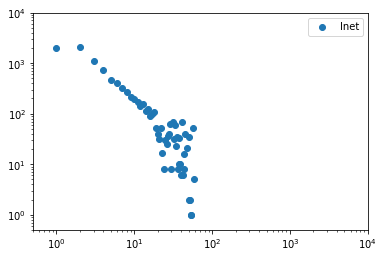

In [18]:
inet = "graphs/inet.txt"
nodes, links = node_link(inet)
print(f"Number of nodes {nodes}")
print(f"Number of links {links}")
inet_graph = load_clean_graph(inet)
triangles = triangle(inet_graph)
print(f"Number of triangles {triangles}")
print(f"Diameter {diameter(inet_graph, 100)}")

plot_degree_dist(inet_graph, my_label = "Inet")

## Exercice 1: generation

### Question 1

Create a Configuration Model of the graph with the same degree sequence as the original graph.

Unfortunately, the version "with rejection" runs too slowly to be used here, so implement the version "with loops and multi-edges deletion" seen in the course.

In [12]:
def add_link(my_link, my_graph):
    '''
    add_link((node1, node2), my_graph)
    
    Add the link ('node1', 'node2') in the graph 'my_graph'
        Parameters:
            (node1, node2) (int, int) : the link  that will be added
            my_graph (dictionary of lists) : the graph that will contain the link
        Returns:    
    '''
    node1, node2 = my_link
    if node1 in my_graph:
        my_graph[node1].append(node2)
    else:
        my_graph[node1] = [node2]
    if node2 in my_graph:
        my_graph[node2].append(node1)
    else:
        my_graph[node2] = [node1]
    return

def build_table(original_graph):
    '''
    Build a table where the node i of the orignal graph where the number
    of occurence of the node i in the table is equal to the degree of the node
        Parameters:
            original_graph (dictionary of lists)
        Returns:
            my_table (list) : the table that represents the original graph
    '''
    my_table = []
    for node in original_graph:
        degree_node = len(original_graph[node])
        for i in range(degree_node):
            my_table.append(node)
    return my_table
def config_model(original_graph):
    '''
    Creates a configuration model of the graph 'original_graph' with the same degree sequence as the original graph
        Parameters:
            original_graph (dictionary of lists) : the original graph
        Returns:
            new_graph (dictionary of lists) : the configuration model of the original graph
    '''
    my_table = build_table(original_graph)
    i = len(my_table)
    new_graph = {}
    while i > 0:
        u = random.randint(0, i - 1)
        my_table[u], my_table[i - 1] = my_table[i - 1], my_table[u]
        v = random.randint(0, i - 2)
        my_table[v], my_table[i - 2] = my_table[i - 2], my_table[v]
        
        node1, node2 = my_table[i - 1], my_table[i - 2]
        loop = node1 == node2
        multi = node2 in new_graph and node1 in new_graph[node2]
        if not loop and not multi:
            add_link((node1, node2), new_graph)
        my_table.pop(i - 1)
        my_table.pop(i - 2)
        i = i - 2
    return new_graph
        
    
    

In [13]:
my_model = config_model(load_clean_graph(inet))
links = 0
for node in my_model:
    links += len(my_model[node])
links = links // 2
nodes = len(my_model)
print("Configuration Model of Inet Graph")
print(f"\tNodes {nodes}")
print(f"\tLinks {links}")


Configuration Model of Inet Graph
	Nodes 9740
	Links 35448


### Question 2

* Compare the initial degree distribution to the configuration model degree distribution. To do so, compute the fraction of nodes which degree is different to the orginal distribution: $ \frac{n_{mod}}{n} $.
* Compare the number of triangles of the configuration model to the one of the original graph, explain in one sentence what you have observed and if it is consistent with what you expected.

In [14]:
def degree_modified(original_graph, config_graph):
    '''
    Compute the fraction of nodes which degree is different to the 
    original distribution
        Parameters:
            original_graph (dictionary of lists)
            config_graph (dictionary of lists)
        
        Returns:
            ratio (int) : the fraction of nodes which degree is different to the
            original distribution
    '''
    node_modified = 0
    for node in config_graph:
        degree_node_config = len(config_graph[node])
        degree_node_origin = len(original_graph[node])
        if degree_node_config != degree_node_origin:
            node_modified += 1
    return node_modified / len(original_graph)


Ratio of degree modified nodes 0.01940451745379877


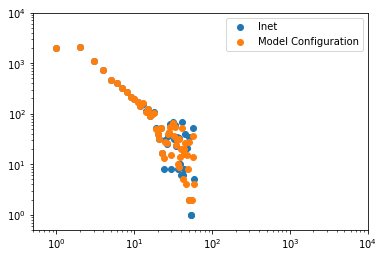

In [19]:
inet_graph = load_clean_graph(inet)
my_model = config_model(inet_graph)
ratio = degree_modified(inet_graph, my_model)
print(f"Ratio of degree modified nodes {ratio}")
plot_degree_dist(inet_graph, my_label="Inet")
plot_degree_dist(my_model, my_label="Model Configuration")

In [23]:
inet_graph = load_clean_graph(inet)
my_model = config_model(inet_graph)
model_triangle = triangle(my_model)
inet_triangle = triangle(inet_graph)
print("Inet")
print(f"\tTriangle {inet_triangle}")
print("Configuration Model for Inet")
print(f"\tTriangle {model_triangle}")

Inet
	Triangle 206909
Configuration Model for Inet
	Triangle 1276


## Exercise 2: robustness analysis

### Question 3

In this question, we want to explore if the original network is more or less robust to attacks than the corresponding configuration model is. 

For this purpose, we follow the same protocol as the one we have seen in PW3: we plot the size of the LCC as a function of a number of nodes removed. Nodes are removed randomly.

Discuss your observations in a few sentences, in particular do you think that the degree distribution alone can explain the robustness to random failures?

In [25]:
inet_graph = load_clean_graph(inet)
my_model = config_model(inet_graph)

In [26]:
model_dic_lcc = random_failure(my_model, 9000, 50)

In [27]:
inet_dic_lcc = random_failure(inet_graph, 9000, 50)

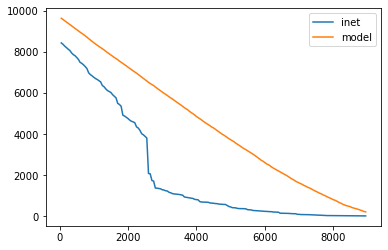

In [28]:
plt.plot(inet_dic_lcc.keys(), inet_dic_lcc.values(), label = "inet")
plt.plot(model_dic_lcc.keys(), model_dic_lcc.values(), label = "Config model")
plt.legend()

## Exercise 3: basic spreading experiment

In this exercise, we implement a basic SI model on the real network and compare it to the same spreading model on the synthetic graph obtained with the Configuration Model.

In a SI model, a node is either Susceptible (S) or Infected (I) and an Infected node cannot go back to the Susceptible status.

### Question 4

Choose a node which is in the largest connected component (LCC) for both the real graph and the synthetic one. It i named the $seed$ of the infection: it is the only infected node at step = 0.

Then, run the following model: 
- at each step, all infected nodes try to infect all their susceptible neighbors in the graph with a probability $p$ (the same for every node).
- the process stops when every node in the LCC is infected.

**Suggestion**: store the infected nodes in a set, and new infected nodes during one round in another set.

Plot the number of infected nodes during the spreading process as a function of the number of steps for both the original graph and the synthetic graph. Compare the two curves and explain what you understand from this comparison.

In [29]:
def bfs_modified(my_graph):
   
    my_cc = {}
    cc_index = 0
    for source in my_graph.keys():
        if source not in my_cc:
            my_queue = [source]
            marked_node = [source]
            while my_queue:
                node1 = my_queue.pop(0)
                my_cc[node1] = cc_index
                for node2 in my_graph[node1]:
                    if node2 not in marked_node:
                        my_queue.append(node2)
                        marked_node.append(node2)
            cc_index += 1
    
    cc_sets = {}
    for node in my_cc:
        cc_index = my_cc[node]
        if cc_index in cc_sets:
            cc_sets[cc_index].add(node)
        else:
            
            cc_sets[cc_index] = {node}
    cc_max = 0
    for cc_index in cc_sets:
        if len(cc_sets[cc_index]) >= len(cc_sets[cc_max]):
            cc_max = cc_index
    return cc_sets[cc_max]

In [31]:
def si_model(lcc, my_graph, p):
    '''
    Return a dictionary representing the evolution of the number of
    infected according to the number of steps
        Parameters:
            lcc (set) : A set containing all the nodes of the largest component connected
            my_graph (dictionary of lists) : the graph
            p (float) : probability of infection
        Returns:
            my_evolution (dictionary)
    '''
    max_infected = len(lcc)
    infecteds = {lcc.pop()}
    step = 0
    my_evolution = {step : len(infecteds)}
    while len(infecteds) < max_infected:
        step += 1
        new_infected = set()
        for infected in infecteds:
            for neighbour in my_graph[infected]:
                tmp = random.uniform(0,1)
                if tmp < p:
                    new_infected.add(neighbour)
        infecteds = infecteds.union(new_infected)
        my_evolution[step] = len(infecteds)
    return my_evolution

In [32]:
inet_graph = load_clean_graph(inet)
my_model = config_model(inet_graph)
p = 0.1
inet_evolution = si_model(bfs_modified(inet_graph), inet_graph, p)
model_evolution = si_model(bfs_modified(my_model), my_model, p)

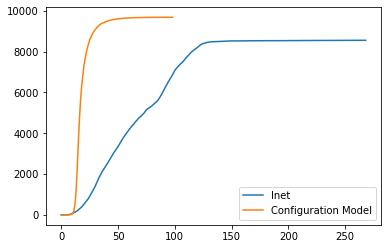

In [35]:
plt.plot(inet_evolution.keys(), inet_evolution.values(), label = "Inet")
plt.plot(model_evolution.keys(), model_evolution.values(), label = "Configuration Model")
plt.legend()